# practicalMixGaussB

The goal of this part of the lab is to fit a mixture of gaussians model to some one-dimensional data. To do this, we will first generate some data from a known mixture of gaussians model and fit our own mixture of gaussians model to the generated data. The parameters from our estimated mixture of gaussians model should roughly match those of the original known model. 

You should use this template for your code and fill in the missing 
sections marked "TO DO."

PLEASE NOTE (again): You should NOT be using functions like multivariate_normal.pdf and normfit or any other numpy functions for fitting your distributions in this or further parts of this practical. Optionally, you can try comparing your results to those produced by those functions, but our goal here is to learn what is happening!

In [75]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.stats import norm
import random
import time

%matplotlib inline

## Construct Ground Truth Mixture of Gaussians Model and Plot Some Points

Define some true parameters for our grounf truth mixture of $k$ Gaussians model. We will represent the mixtures of Gaussians as a python dictionary. Not that we are working in one dimension, but if we were to require $d$ dimenisions, the mean field would be a $d \times k$ matrix and the cov field would be a $d \times d \times k$ matrix. 

In [76]:
mixGaussTrue = dict()
mixGaussTrue['k'] = 2 # number of gaussians
mixGaussTrue['d'] = 1 # dimension of the data
mixGaussTrue['weight'] = np.array([0.3, 0.7]) # weight assigned to each gaussian
mixGaussTrue['mean'] = np.array([[-1,1.5]]) # the mean for each gaussian 
mixGaussTrue['cov'] = np.reshape([0.5, 0.25], newshape=(1,1,2)) # the covariance for each gaussian

**getGaussProb**, **sampleFromDiscrete**, and **drawEMData1d** are helper functions. 

In [77]:
# subroutine to return gaussian probabilities
def getGaussProb(x,mean,var):   
    """
    Returns the likelihood that each data point in x belongs to the Gaussian described by mean and 
    var.
    
    Keyword arguments:
    x -- 1 by n vector of data points. n is the number of data points.
    mean -- scalar containing the mean parameter of the Gaussian distribution.
    var -- scalar containing the variance parameter of the Gaussian distribution.
    
    Returns: 
    prob -- scalar contianing the likelihood that each data point in data belongs to the Gaussian 
    distribution defined by mean and var.
    """
    mean = np.squeeze(mean)                                        
    var = np.squeeze(var)                                          
    prob = np.exp(-0.5*((x-mean)**2)/(var))                        
    prob = prob/ np.sqrt(2*np.pi*var)                              
    return prob                                                    

In [78]:
def sampleFromDiscrete(probDist): 
    """
    Draws a random sample from a discrete probability distribution using a rejection sampling method.  
    
    Keyword arguments:
    probDist -- discrete probability ditrubtion to sample from.
    
    Returns: 
    r -- sampled point.
    """

    nIndex = len(probDist)                                                                 
    while True:                                                                            
        #choose random index                                                               
        r=int(np.floor(np.random.uniform()*nIndex))                                        
        #choose random height                                                              
        randHeight = np.random.uniform()                                                   
        #if height is less than probability value at this point in the                     
        # histogram then select                                                            
        if randHeight<probDist[r]:                                                         
            break                                                                          
    return r                                                                               

In [79]:
def drawEMData1d(data, mixGauss):
    """
    Draw the data, data, in histogram form and plot the mixtures of Gaussian model, mixGauss, on top of it.
    
    Keyword arguments:
    data -- 1 by n vector of data points.
    mixGauss -- dict with mixture of gaussian information.

    """
    # delete previous plot if it exists                                                                   
    # hold off;                                                                                           
    # bin the data to make a histogram                                                                    
                                                                                                          
    binWidth = 0.1;                                                                                       
    binMin = -4.0;                                                                                        
    binMax = 4.0;                                                                                         
    nSteps = int(np.ceil((binMax - binMin) / binWidth))                                                   
                                                                                                          
    nDims, nData = data.shape                                                                             
                                                                                                          
    xHist = np.linspace(binMin, binMax, nSteps, endpoint=True)                                            
    xHistExt = np.append(xHist, np.inf)                                                                   
    yHist, _ = np.histogram(data, xHistExt)                                     
                                                                                                          
    yHist = yHist / (nData * binWidth)                                                                    
    plt.cla()                                                                                     
    plt.bar(xHist, yHist, binWidth, edgecolor='b')                                                        
                                                                                                          
    # calculate Gaussian data                                                                             
    nGauss = mixGauss['k']                                                                                
    gaussEnvEst = np.zeros(xHist.shape)                                                                   
    for cGauss in range(nGauss):                                                                          
        # calculate weighted Gaussian values                                                              
        gaussProb = mixGauss['weight'][cGauss] * getGaussProb(xHist, mixGauss['mean'][:,cGauss],          
                                                              mixGauss['cov'][:, :, cGauss])              
        plt.plot(xHist, gaussProb, 'm-')  # weighted components of MoG                                    
        # add to form envelope                                                                            
        gaussEnvEst = gaussEnvEst + gaussProb                                                             
                                                                                                          
    plt.plot(xHist, gaussEnvEst, 'g-')  # final mixture of Gaussians                                      
                                                                                                          
    # tidy up plot                                                                                        
    plt.xlabel('Data Value')                                                                              
    plt.ylabel('Probability Density')                                                                     
    # set(gca,'Box','Off');                                                                               
    # set(gcf,'Color',[1 1 1]);                                                                           
    plt.xlim((binMin, binMax))                                                                            
    plt.ylim((0, max(yHist) * 1.5))                                                                       
                                                                                                          
    return                                                                                                
    

**TODO D HERE:**

Complete the TO DO in this function before moving on. 



Here we generate sample data from a normal distribution with mean m and variance s^2 using the formula sample = s^2*x + m, where x is a sample from the standard normal distribution with mean 0 and s^2 equal to 1. We randomly choose the distribution (h=1 or h=2) from which we generate a point at each iteration. 

In [80]:
def mixGaussGen1d(mixGauss, nData):  
    """
    Generates data from a one-dimensional mixture of Gaussians model. 
    
    Keyword arguments:
    mixGauss -- dict containing the mixture of gaussians arguments.
    nData -- number of data points to generate.
    
    Returns: 
    data -- 1 by nData, generated data points. 
    """
    
    # create space for output data                                                                               
    data = np.zeros(shape=(1, nData))                                                                            
    # for each data point                                                                                        
    for cData in range(nData):
        
        # randomly choose Gaussian according to probability distributions                                        
        h = sampleFromDiscrete(mixGauss['weight'])
        
        # randomly draw a sample from the appropriate Gaussian distribution
        sample = mixGauss.get('cov')[0][0][h]*np.random.randn(1) + mixGauss.get('mean')[0][h]
        
        # store the smaple we just created 
        data[:, cData] = sample
        
                                                                                                         
    return data                                                                                                  

With all the helper functions complete, we can now generate and plot some points from our model. The blue bars are the histogram of the generated points. The green curve is what the complete mixture of gaussians model looks like. The pink curves are the component gaussians. 

The graph below depicts the ground truth dataset we already created drawing randomly poits from the two gaussians. The green graphs represent the initial ground truth normal distributions that we are sampling data from.

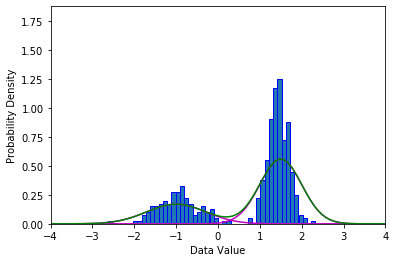

In [81]:
# define number of samples to generate
nData = 400;

#generate data from the mixture of Gaussians
#make sure you've filled out the todo above! 
data = mixGaussGen1d(mixGaussTrue,nData)

fig,ax = plt.subplots(1,1)
drawEMData1d(data,mixGaussTrue)

## Estimate MoG using the E-M Algorithm
Here we want to use the E-M algorithm to fit a MoG model to our data points. 

**TODO E HERE:** 

Fill out the missing parts below. 

In [82]:
def getMixGaussBound(data, mixGaussEst, responsibilities):                                                  
    """
    Calculate the bound on the log likelihood for the whole data set under a mixture of Gaussians model.  
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.
    responsibilities -- k by n vector containing the responsibility of this data point for each Gaussian. 
    
    Returns: 
    bound -- scalar containing the bound on the log likelihood.
    
    """
    # find total number of data items                                                                       
    nDims, nData = data.shape                                                                               
                                                                                                            
    # initialize bound                                                                                      
    bound = 0                                                                                               
    
        
    i = -1
    # run through each data item                                                                            
    for cData in range(data.shape[1]):
        i += 1
        # extract this data                                                                                 
        thisData = data[:, cData]
        
        # extract this q(h)                                                                                 
        thisQ = responsibilities[:, cData]                                                                  
                                                                                                            
        # TO DO (e) - calculate contribution to bound of this datapoint                                         
        # Replace this                                                                                      
        boundValue = 0
        
        for k in range(0,mixGaussEst.get('k')):
            
            l = mixGaussEst.get('weight')[k]
            norm = getGaussProb(thisData,mixGaussEst.get('mean')[0][k],mixGaussEst.get('cov')[0][0][k])[0]
            r = thisQ[k]
            boundValue += r*np.log((l*norm)/r)
            
        # add to total log like                                                                             
        bound = bound + boundValue
                                                                                                            
    return np.asscalar(np.array(bound))                                                                          

**TODO F HERE:** 

Fill out the missing parts below. 

The log likelihood is taken since the raw likelihood value could be too small for our machine's percision. 

In [83]:
def getMixGaussLogLike(data, mixGaussEst):
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    
    data = np.atleast_2d(data)                                                                                                                                             
    
    # initialize log likelihoods                                                                       
    logLike = 0;                                                                                       
                                                                                                       
    # run through each data item                                                                       
    for cData in range(data.shape[1]):
        
        thisData = data[:, cData]    
        
        # TO DO (f) - calculate likelihood of this data point under mixture of                         
        # Gaussians model. Replace this                                                                
        like = 0
        for k in range(0,mixGaussEst.get('k')):
            l = mixGaussEst.get('weight')[k]
            norm = getGaussProb(thisData,mixGaussEst.get('mean')[0][k],mixGaussEst.get('cov')[0][0][k])[0]
            like += l*norm   
        # add to total log like                                                                        
        logLike = logLike + np.log(like)                                                               
                                                                                                       
    return  np.asscalar(np.array(logLike))                                                                       
                                                                                                       

In [84]:
def E_step(responsibilities,mixGaussEst,data):
    
    curCov = mixGaussEst['cov']                                                                             
    curWeight = mixGaussEst['weight']                                                                            
    curMean = mixGaussEst['mean']
    
    l = np.zeros((mixGaussEst.get('k'),data.shape[1]),dtype=np.float64)
    r = np.zeros((mixGaussEst.get('k'),data.shape[1]),dtype=np.float64)

    i = -1
    for cData in range(data.shape[1]):
        i += 1
        
        thisData = data[:, cData] 
        
        sum_l = 0
        for k in range(0,mixGaussEst.get('k')):
            
            norm = getGaussProb(thisData,mixGaussEst.get('mean')[0][k],mixGaussEst.get('cov')[0][0][k])
            ll = mixGaussEst.get('weight')[k]*norm
            l[k][i] = ll[0]
            sum_l += l[k][i]
        
        for k in range(0,mixGaussEst.get('k')):
            r[k][i] = l[k][i]/sum_l
                                                                                                
    return r

In [85]:
def M_step(k,mixGaussEst,responsibilities,data):
    
    
    
    # ===================== =====================                                                                
    # Maximization Step                                                                                          
    # ===================== =====================  
    

    # for each latent variable refered to each Gaussian                                                                              
    for cGauss in range(k):
        
        r = 0
        for i in range(data.shape[1]):
            r += responsibilities[cGauss][i]
            
            
        # TO DO:  Update weighting parameters mixGauss.weight based on the total                                 
        # posterior probability associated with each Gaussian. Replace this:                                         
        
    
        sum_l = 0
        for kk in range(k):
            for ii in range(data.shape[1]):
                sum_l += responsibilities[kk][ii]
                    
                    
        
        mixGaussEst['weight'][cGauss] = r/sum_l
                    
            
        # TO DO:  Update mean parameters mixGauss.mean by weighted average                                       
        # where weights are given by posterior probability associated with                                       
        # Gaussian. 
        
        i = -1
        sum_m = 0
        for cData in range(data.shape[1]):
            i += 1
            
            thisData = data[:, cData]
            sum_m += (responsibilities[cGauss][i]*thisData)      
            
       
        mixGaussEst['mean'][:,cGauss] = sum_m/r
        
            
            
        # TO DO:  Update covarance parameter based on weighted average of                                        
        # square distance from update mean, where weights are given by                                           
        # posterior probability associated with Gaussian
        
        
        i = -1
        sum_s = 0
        for cData in range(data.shape[1]):
            i += 1
            
            thisData = data[:, cData]
            
            new_mean = mixGaussEst['mean'][:,cGauss]
            
            mu_matrix = (thisData - new_mean)**2
            sum_s += (responsibilities[cGauss][i]*mu_matrix)
        
        mixGaussEst['cov'][:,:,cGauss] = sum_s/r
            
    return mixGaussEst

**TODO G HERE:** 

Fill out the missing parts below. 

In [86]:
def fitMixGauss1d(data, k):
    
    #print(data.shape)
    #print(k)
    #return

    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape                                                                                        
                                                                                                                                                                                                                  
    responsibilities = np.zeros(shape=(k, nData))
                                                                                                                     
    # we will initialize the values to random values                                                                 
    mixGaussEst = dict()                                                                                             
    mixGaussEst['d'] = 1                                                                                             
    mixGaussEst['k'] = k                                                                                             
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))                                                             
    mixGaussEst['mean'] = 2 * np.random.randn(1, k)                                                                  
    mixGaussEst['cov'] = 0.1 + 1.5*np.random.uniform(size=(1,1,2))
    
    # calculate current likelihood                                                                                                                                                                   
    logLike = getMixGaussLogLike(data, mixGaussEst)                                                                  
                                                                                                            
    nIter = 20;                                                                                                      
                                                                                                                     
    logLikeVec = np.zeros(shape=(2 * nIter))                                                                         
    boundVec = np.zeros(shape=(2 * nIter)) 
    
    fig,ax = plt.subplots(1,1)
                                                                                                                     
    for cIter in range(nIter):                                                                                       
        
        
        # expectation step -- calculate the new responsibilities
        responsibilities = E_step(responsibilities,mixGaussEst,data)

        # calculate the log likelihood                                                                               
        logLike = getMixGaussLogLike(data, mixGaussEst)                                                                                            
                                                                                                                     
        # calculate the bound                                                                                                                                                                       
        bound = getMixGaussBound(data, mixGaussEst, responsibilities)                                                
        
        logLikeVec[2 * cIter] = logLike                                                                              
        boundVec[2 * cIter] = bound
        
        ### maximisation step -- update distributions based on the new responsibilities
        mixGaussEst = M_step(k,mixGaussEst,responsibilities,data)
                                                                                                              
        # draw the new solution  
        drawEMData1d(data, mixGaussEst)
        time.sleep(3)
        fig.canvas.draw()
                                                                                                                     
        # calculate the log likelihood                                                                               
        logLike = getMixGaussLogLike(data, mixGaussEst)                                                                                            
                                                                                                                     
        # calculate the bound                                                                                        
        bound = getMixGaussBound(data, mixGaussEst, responsibilities)                                                
                                                                                                                  
        logLikeVec[2 * cIter + 1] = logLike                                                                          
        boundVec[2 * cIter + 1] = bound
                                                                                                                     
    plt.figure()                                                                                                     
    plt.plot(logLikeVec, 'g',label='log likelihood')                                                                                        
    plt.plot(boundVec, 'r',label='lower bound')  
    plt.legend()
                                                                                                                     
    return mixGaussEst                                                                                               

### Time to put it all together!
Make sure you've filled all the TO DOs above! 

/home/apostolos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Final Gaussian Mixture: {'d': 1, 'k': 2, 'weight': array([0.2750336, 0.7249664]), 'mean': array([[-1.01264138,  1.48562468]]), 'cov': array([[[0.25475059, 0.05703398]]])}


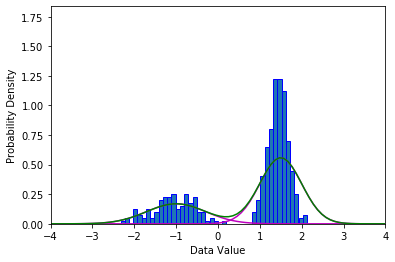

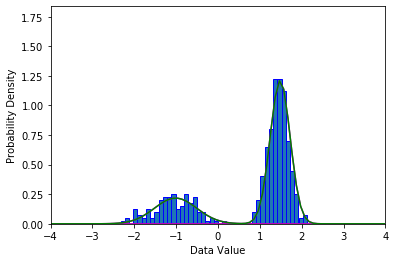

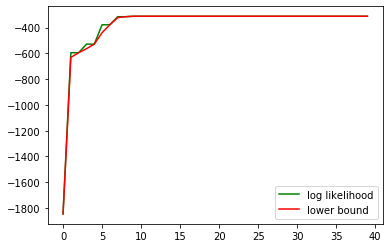

In [87]:
#generate data from the ground truth mixture of Gaussians we've defined way above. 
#make sure you've completed this routine above.
data = mixGaussGen1d(mixGaussTrue,nData);

#draw data, ground truth mixture of Gaussians.
drawEMData1d(data,mixGaussTrue)

#define number of components to estimate
nGaussEst = 2

#fit mixture of Gaussians (Pretend someone handed you some data. Now what?)
#Make sure you've completed this routine above.
mixGaussEst = fitMixGauss1d(data,nGaussEst)

print("Final Gaussian Mixture: " + str(mixGaussEst))

Firstly, we plot the dictionary with the Parameters of the gaussian distribution we learned with the EM algorithm.
Regarding the pictures the first represents the ground truth distribution and the second the estimated based on the parameters we found with the EM algorithm. The last figure illustrates the log likelihood and its lower bound for all the iterations of our algorithm. We can clearly see that the likelihhod (green line) increases as we are achieving a better approximation of the distribution and its lower bound (red line) is allways lower than the log likelihood (green line). Both these observations seem reasonable.